# Read Boost-Factor Implementation

Here in this notebook I understand eabdelaz implementation of Boost Factor.

- Boost-Factor Fit On Fake Data
- Check Fit: Plot Fit And Data
- Read Boost-Factor Data

In [1]:
import numpy as np
import corner
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

## Boost-Factor Fit: Fake Data

In [3]:
from Boost_factor_util import Boost_Factor_Model

In [4]:
R = np.logspace(np.log10(0.05),2,100); # print(*R, sep=" ")
#R=p.logspace(0,1.5,2)

# true model
B0 = 1.5
R0 = 0.5
B = Boost_Factor_Model(R, R0, B0)

# add noise
variance = np.ones(B.size)*0.1**2
sigma_B  = B*np.random.normal(loc=0, scale=variance**(1/2), size=B.size) #results in log noise
data = B + sigma_B
chi_sq = ((B)-(data))**2/sigma_B**2
print(chi_sq.sum()/(B.size -1))



1.0101010101010115


Text(0, 0.5, '$f_{\\rm cls}$')

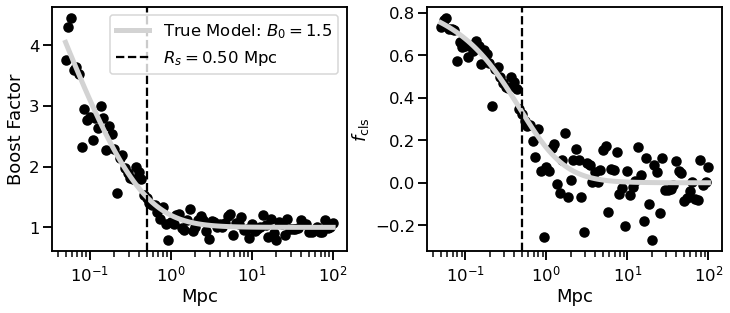

In [5]:
plt.figure(figsize=(12,4.5))
plt.subplots_adjust(wspace=0.275)

plt.subplot(1,2,1)
plt.xscale('log')
plt.plot(R, B, lw=5, color='lightgray',label=r'True Model: $B_0 =%.1f $'%(B0));
plt.scatter(R, data, color='k')
plt.axvline(R0, color='k', ls='--', label=r'$R_s=%.2f$ Mpc'%R0)
plt.xlabel("Mpc"); plt.ylabel('Boost Factor')
plt.legend()

plt.subplot(1,2,2)
plt.xscale('log')
plt.scatter(R, 1-1/data, color='k')
plt.plot(R, 1-1/B, lw=5, color='lightgray');
plt.axvline(R0, color='k', ls='--', label=r'$R_s=%.2f$'%R0)
plt.xlabel("Mpc"); plt.ylabel(r'$f_{\rm cls}$')


### Test Model Function With Curve Fit

In [6]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(Boost_Factor_Model, R, data)
popt

array([0.46447745, 1.56641972])

In [7]:
np.diag(pcov)

array([0.00256292, 0.01261859])

## Run Cosmosis

```cosmosis boost_factor_test.ini >& log &```

## Check w/ Realistic Priors

A first check of the pipeline is to set realistic prior. The boost-factor fitted values for McClintock et al. 2018 are displayed below.

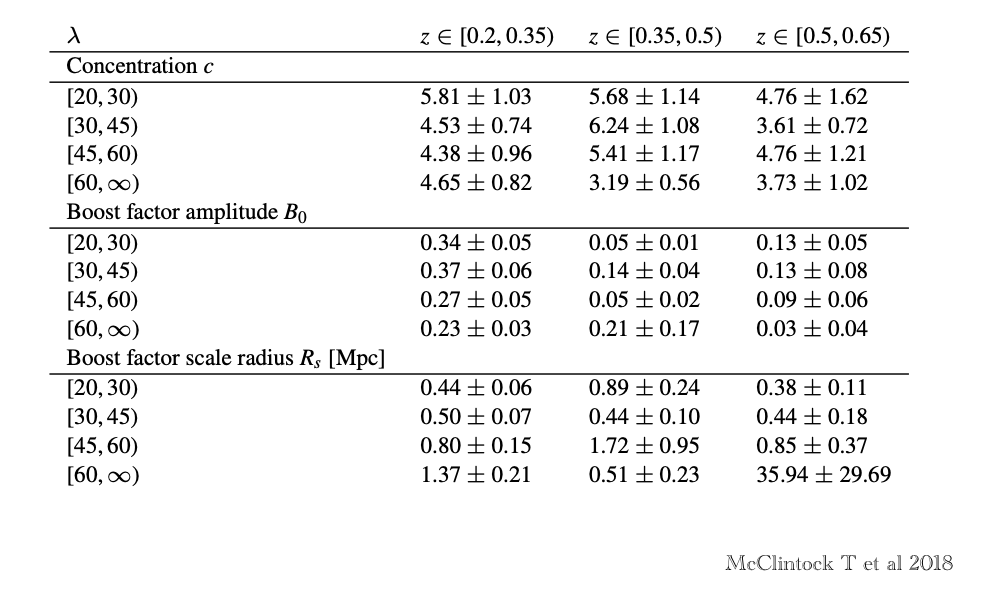

In [8]:
# fit Boost_Factor_param function
priors = dict()
priors['rs'] = np.array([[0.44, 0.50, 0.80, 1.37],[0.89, 0.44, 1.72, 0.51],[0.38, 0.44, 0.85, np.nan]])
priors['rs_err'] = np.array([[0.06, 0.07, 0.15, 0.21],[0.24, 0.10, 0.95, 0.23],[0.11, 0.18, 0.37, np.nan]])

priors['b0'] = np.array([[0.34, 0.37, 0.27, 0.23],[0.05, 0.14, 0.05, 0.21],[0.13, 0.13, 0.09,0.03]])
priors['b0_err'] = np.array([[0.05, 0.06, 0.05, 0.03],[0.01, 0.04, 0.02, 0.17],[0.05, 0.08, 0.06, 0.04]])

priors['lambda'] = np.array([[25, 40, 50, 70],[25, 40, 50, 70],[25, 40, 50, 70]])
priors['redshift'] = np.array([[0.3, 0.3, 0.3, 0.3],[0.4, 0.4, 0.4, 0.4],[0.6, 0.6, 0.6, 0.6]])

Text(0.5, 1.0, 'Boost-Factor: rs')

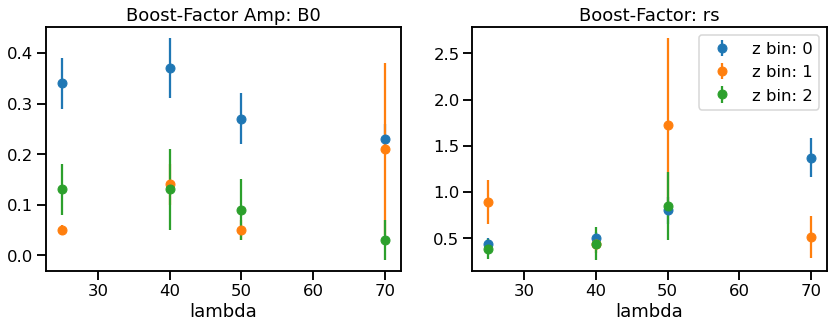

In [9]:
plt.figure(figsize=(14,4.5))

plt.subplot(1,2,1)
for i in range(3):
    plt.errorbar(priors['lambda'][i], priors['b0'][i], yerr=priors['b0_err'][i], fmt='o', label='z bin: %i'%i)
# plt.legend(ncol=1)
plt.xlabel('lambda')
plt.title('Boost-Factor Amp: B0')

plt.subplot(1,2,2)
for i in range(3):
    plt.errorbar(priors['lambda'][i], priors['rs'][i], yerr=priors['rs_err'][i], fmt='o', label='z bin: %i'%i)
    
plt.legend(ncol=1)
plt.xlabel('lambda')
plt.title('Boost-Factor: rs')

### Johnny's Comment 
Is this linear relation motivated? By taking a look at the data I see that's kind hard to fit this linear relation with the redshift and lambda.
```
def Boost_Factor_param(Z,L,Rs,alpha_Rs,beta_Rs,B0,alpha_B0,beta_B0):
    """This function takes the priors from the values file and calculates rs and b0 values for the model given redshift and lambda
    """
    rs =Rs*(Z/(1+0.3))**alpha_Rs*(L/30.)**beta_Rs
    b0= B0*((Z)/(1+0.3))**alpha_B0*(L/30.)**beta_B0
    return rs,b0
```



In [10]:
def Boost_Factor_param(Z,L,Rs,alpha_Rs,beta_Rs,B0,alpha_B0,beta_B0):
    """This function takes the priors from the values file and calculates rs and b0 values for the model given redshift and lambda
    """
    rs =Rs*(Z/(1+0.3))**alpha_Rs*(L/30.)**beta_Rs
    b0= B0*((Z)/(1+0.3))**alpha_B0*(L/30.)**beta_B0
    return rs,b0



In [11]:
def _Boost_Factor_fit_rs(x, Rs0, alpha_Rs, beta_Rs):
    """This function takes the priors from the values file and calculates rs and b0 values for the model given redshift and lambda
    """
    # unpack variables
    Z, L = x
    rslog = np.log(Rs0) + alpha_Rs*np.log(Z/(1+0.3)) + beta_Rs*np.log(L/30.)
    return rslog

def _Boost_Factor_fit_b0(x, B0, alpha_B0, beta_B0):
    """This function takes the priors from the values file and calculates rs and b0 values for the model given redshift and lambda
    """
    # unpack variables
    Z, L = x
    b0log = np.log(B0) + alpha_B0*np.log(Z/(1+0.3)) + beta_B0*np.log(L/30.)
    return b0log

In [12]:
Z = priors['redshift']
L = priors['lambda']
Rs = priors['rs']
B0 = priors['b0']
Rs[np.isnan(Rs)] = np.nanmedian(Rs)

# current priors on the slope
alpha_B0 = 1.
beta_B0  = 1.

alpha_Rs = 1.
beta_Rs = 1.

params = [alpha_Rs, beta_Rs, alpha_B0, beta_B0]
x = (np.c_[Z.flatten(),L.flatten()]).T
y = (np.c_[Rs.flatten(), B0.flatten()]).T

In [13]:
from scipy.optimize import curve_fit

popt, pcov = curve_fit(_Boost_Factor_fit_rs, (x[0], x[1]), np.log(y[0]))
popt_b, pcov_b = curve_fit(_Boost_Factor_fit_b0, (x[0], x[1]), np.log(y[1]))

rs_fit = np.exp(_Boost_Factor_fit_rs((x[0], x[1]), *popt))
rs_fit = rs_fit.reshape(priors['rs'].shape)

b0_fit = np.exp(_Boost_Factor_fit_b0((x[0], x[1]), *popt_b))
b0_fit = b0_fit.reshape(priors['b0'].shape)

/tmp/ipykernel_39771/1982887726.py:6: RuntimeWarning: invalid value encountered in log
  rslog = np.log(Rs0) + alpha_Rs*np.log(Z/(1+0.3)) + beta_Rs*np.log(L/30.)
/tmp/ipykernel_39771/1982887726.py:14: RuntimeWarning: invalid value encountered in log
  b0log = np.log(B0) + alpha_B0*np.log(Z/(1+0.3)) + beta_B0*np.log(L/30.)


In [14]:
model = dict()
model['rs'] = popt
model['b0'] = popt_b

model['rs_err'] = np.diag(pcov)
model['b0_err'] = np.diag(pcov_b)

Text(0.5, 1.0, 'Boost-Factor: rs')

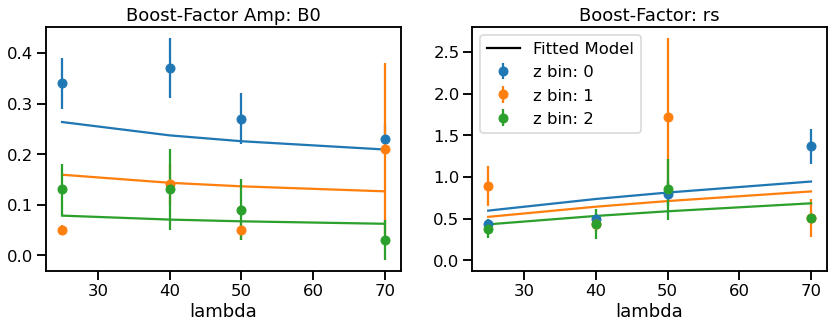

In [15]:
plt.figure(figsize=(14,4.5))

plt.subplot(1,2,1)
for i in range(3):
    p = plt.plot(priors['lambda'][i], b0_fit[i])
    plt.errorbar(priors['lambda'][i], priors['b0'][i], yerr=priors['b0_err'][i], fmt='o', label='z bin: %i'%i, color=p[0].get_color())
    
# plt.legend(ncol=1)
plt.xlabel('lambda')
plt.title('Boost-Factor Amp: B0')

plt.subplot(1,2,2)
for i in range(3):
    p = plt.plot(priors['lambda'][i], rs_fit[i])
    plt.errorbar(priors['lambda'][i], priors['rs'][i], yerr=priors['rs_err'][i], fmt='o', label='z bin: %i'%i, color=p[0].get_color())

plt.plot([30], [0.], color='k', label='Fitted Model')
plt.legend(ncol=1)
plt.xlabel('lambda')
plt.title('Boost-Factor: rs')



Text(0.5, 1.0, 'Boost-Factor: rs')

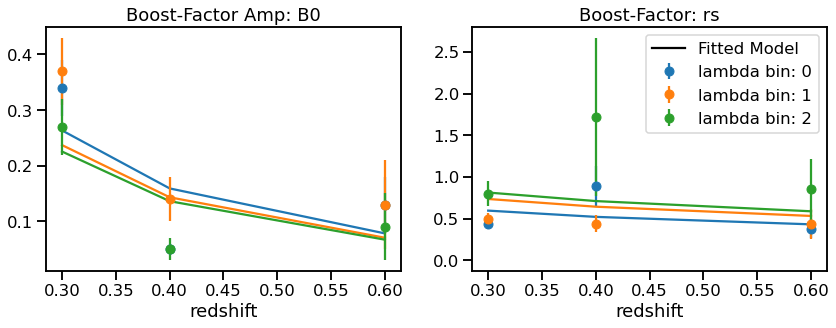

In [16]:
plt.figure(figsize=(14,4.5))

plt.subplot(1,2,1)
for i in range(3):
    p = plt.plot(priors['redshift'][:,i], b0_fit[:,i])
    plt.errorbar(priors['redshift'][:,i], priors['b0'][:,i], yerr=priors['b0_err'][:,i], fmt='o', label='lambda bin: %i'%i, color=p[0].get_color())
    
# plt.legend(ncol=1)
plt.xlabel('redshift')
plt.title('Boost-Factor Amp: B0')

plt.subplot(1,2,2)
for i in range(3):
    p = plt.plot(priors['redshift'][:,i], rs_fit[:,i])
    plt.errorbar(priors['redshift'][:,i], priors['rs'][:,i], yerr=priors['rs_err'][:,i], fmt='o', label='lambda bin: %i'%i, color=p[0].get_color())

plt.plot([0.3], [0.], color='k', label='Fitted Model')
plt.legend(ncol=1)
plt.xlabel('redshift')
plt.title('Boost-Factor: rs')

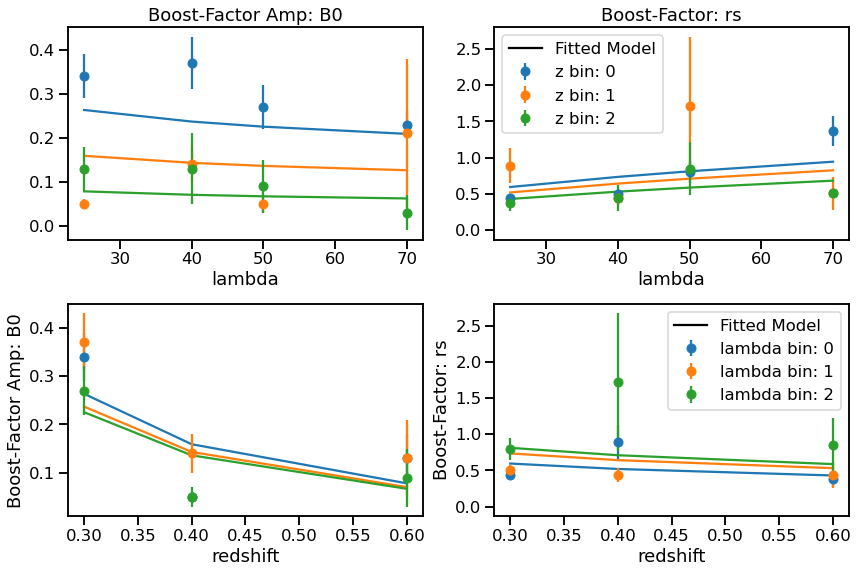

In [17]:
plt.figure(figsize=(14,9))

plt.subplot(2, 2, 1)

for i in range(3):
    p = plt.plot(priors['lambda'][i], b0_fit[i])
    plt.errorbar(priors['lambda'][i], priors['b0'][i], yerr=priors['b0_err'][i], fmt='o', label='z bin: %i'%i, color=p[0].get_color())
    
# plt.legend(ncol=1)
plt.xlabel('lambda')
plt.title('Boost-Factor Amp: B0')

plt.subplot(2,2,2)
for i in range(3):
    p = plt.plot(priors['lambda'][i], rs_fit[i])
    plt.errorbar(priors['lambda'][i], priors['rs'][i], yerr=priors['rs_err'][i], fmt='o', label='z bin: %i'%i, color=p[0].get_color())

plt.plot([30], [0.], color='k', label='Fitted Model')
plt.legend(ncol=1)
plt.xlabel('lambda')
plt.title('Boost-Factor: rs')

plt.subplot(2,2,3)
for i in range(3):
    p = plt.plot(priors['redshift'][:,i], b0_fit[:,i])
    plt.errorbar(priors['redshift'][:,i], priors['b0'][:,i], yerr=priors['b0_err'][:,i], fmt='o', label='lambda bin: %i'%i, color=p[0].get_color())
    
# plt.legend(ncol=1)
plt.xlabel('redshift')
plt.ylabel('Boost-Factor Amp: B0')

plt.subplot(2,2,4)
for i in range(3):
    p = plt.plot(priors['redshift'][:,i], rs_fit[:,i])
    plt.errorbar(priors['redshift'][:,i], priors['rs'][:,i], yerr=priors['rs_err'][:,i], fmt='o', label='lambda bin: %i'%i, color=p[0].get_color())

plt.plot([0.3], [0.], color='k', label='Fitted Model')
plt.legend(ncol=1)
plt.xlabel('redshift')
plt.ylabel('Boost-Factor: rs')
plt.subplots_adjust(hspace=0.3)

In [318]:
def get_prior_range(label,data=priors):
    p16,mean,p84 = np.percentile(data[label].ravel(),[2.5,50,97.5])
    return mean, p16, p84

In [319]:
labels = ['amp','alpha','beta']

In [321]:
print(5*'---------')
print('Realistic Priors: Boost Factor Model')
print('')
for label in ['rs','b0']:
    print('Parameter: %s'%label)
    print('mean, 95%%c.l: %.2f, %.2f, %.2f'%(get_prior_range(label)))
    for i in range(3):
        tag = '%s_%s'%(labels[i],label)
        print('%s: %.3f +/- %.3f'%(tag,model[label][i],model[label+'_err'][i]))

    print('')

---------------------------------------------
Realistic Priors: Boost Factor Model

Parameter: rs
mean, 95%c.l: 0.51, 0.40, 1.62
amp_rs: 0.325 +/- 0.037
alpha_rs: -0.468 +/- 0.240
beta_rs: 0.449 +/- 0.139

Parameter: b0
mean, 95%c.l: 0.14, 0.04, 0.36
amp_b0: 0.019 +/- 0.000
alpha_b0: -1.752 +/- 0.476
beta_b0: -0.225 +/- 0.275



### Run with Fixed Slope

No evolution with redshift or lambda. 

In [2]:
!head -n 50 logs/log_fixed_slope_tight

DEBUG:root:CosmoSIS verbosity set to 40
INFO:root:Generating random starting positions from within prior
**** WARNING: Parameter 'r' in the [BoostFactor] section never used!


Parameter Priors
----------------
cosmological_parameters--h0          ~ delta(0.7)
cosmological_parameters--omega_m     ~ delta(0.3)
cosmological_parameters--omega_b     ~ delta(0.05649329977)
cosmological_parameters--omega_k     ~ delta(0.0)
cosmological_parameters--tau         ~ delta(0.08)
cosmological_parameters--n_s         ~ delta(0.975589)
cosmological_parameters--log1e10as   ~ delta(3.092918)
cosmological_parameters--w           ~ delta(-1.0)
cosmological_parameters--wa          ~ delta(0.0)
cosmological_parameters--massive_nu  ~ delta(1)
cosmological_parameters--omega_nu    ~ delta(0.0)
cluster_mass_profile--concentration  ~ delta(4.3)
photoz--delta_z                      ~ delta(0.0)
cluster_abundance--fcen              ~ delta(1.0)
cluster_abundance--mor_a             ~ delta(90124651837.9)
cluster_ab

In [4]:
path = 'outputs/'
samples= np.genfromtxt(path+"boost_factor_emcee_fixed_slope_tight.txt"); 
params = np.genfromtxt(path+"boost_factor_emcee_fixed_slope_tight.txt", max_rows=1, comments = "%" ,dtype=str);

In [5]:
samples.shape

(500000, 4)

In [6]:
Ndiscard = 100
samples = samples[Ndiscard:,:-2]; 

Boost_Factor_Model_Values--b0
#Boost_Factor_Model_Values--rs


Text(0.5, 1.0, '#Boost_Factor_Model_Values--rs')

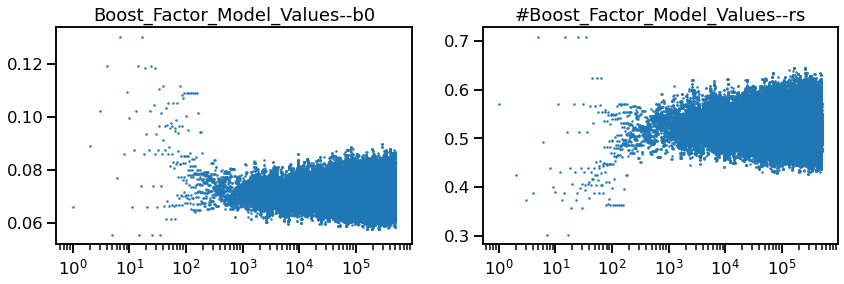

In [7]:
plt.figure(figsize=(14,4.))
plt.subplot(1, 2, 1)
column = 1; print(params[column]);
plt.xscale('log')
plt.scatter(np.arange(samples[100:,column].size),samples[100:,column], s =1);
plt.title(params[column])

plt.subplot(1, 2, 2)
column = 0; print(params[column]);
plt.xscale('log')
plt.scatter(np.arange(samples[100:,column].size),samples[100:,column], s =1);
plt.title(params[column])

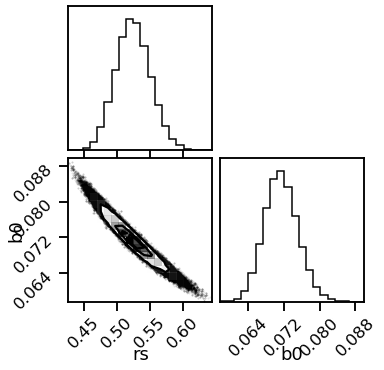

In [8]:
figure = corner.corner(samples[2000:,:],labels=['rs','b0'])

In [9]:
b0_best = np.median(samples[:,1])
b0_best

0.0712699085874974

In [10]:
rs_best = np.median(samples[:,0])
rs_best

0.5241399909007729

In [11]:
np.std(samples[:,0])

0.026367348284387734

In [435]:
R = np.logspace(np.log10(0.05),np.log10(6),100); # print(*R, sep=" ")
#R=p.logspace(0,1.5,2)

# true model
B0 = b0_best
R0 = rs_best
B = Boost_Factor_Model(R, R0, B0)

# add noise
variance = np.ones(B.size)*0.05**2
sigma_B  = B*np.random.normal(loc=0, scale=variance**(1/2), size=B.size) #results in log noise
data = B + sigma_B
chi_sq = ((B)-(data))**2/sigma_B**2
print(chi_sq.sum()/(B.size -1))

1.0101010101010028


Text(0, 0.5, '$f_{\\rm cls}$')

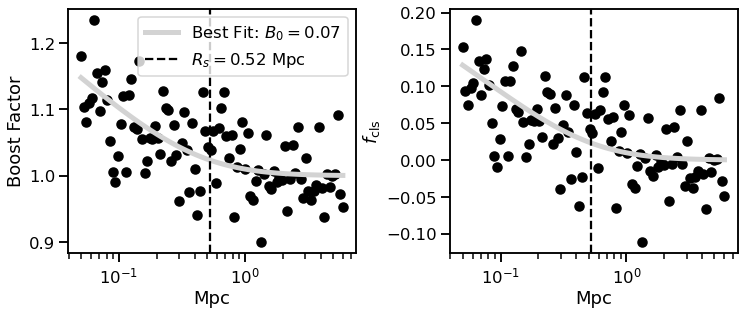

In [437]:
plt.figure(figsize=(12,4.5))
plt.subplots_adjust(wspace=0.325)

plt.subplot(1,2,1)
plt.xscale('log')
plt.plot(R, B, lw=5, color='lightgray',label=r'Best Fit: $B_0 =%.2f $'%(B0));
plt.scatter(R, data, color='k')
plt.axvline(R0, color='k', ls='--', label=r'$R_s=%.2f$ Mpc'%R0)
plt.xlabel("Mpc"); plt.ylabel('Boost Factor')
plt.legend()

plt.subplot(1,2,2)
plt.xscale('log')
plt.scatter(R, 1-1/data, color='k')
plt.plot(R, 1-1/B, lw=5, color='lightgray');
plt.axvline(R0, color='k', ls='--', label=r'$R_s=%.2f$'%R0)
plt.xlabel("Mpc"); plt.ylabel(r'$f_{\rm cls}$')


### Run With Slope

No evolution with redshift or lambda. 

In [12]:
!head -n 50 logs/log_with_slope

DEBUG:root:CosmoSIS verbosity set to 40
INFO:root:Generating random starting positions from within prior
**** WARNING: Parameter 'r' in the [BoostFactor] section never used!


Parameter Priors
----------------
cosmological_parameters--h0          ~ delta(0.7)
cosmological_parameters--omega_m     ~ delta(0.3)
cosmological_parameters--omega_b     ~ delta(0.05649329977)
cosmological_parameters--omega_k     ~ delta(0.0)
cosmological_parameters--tau         ~ delta(0.08)
cosmological_parameters--n_s         ~ delta(0.975589)
cosmological_parameters--log1e10as   ~ delta(3.092918)
cosmological_parameters--w           ~ delta(-1.0)
cosmological_parameters--wa          ~ delta(0.0)
cosmological_parameters--massive_nu  ~ delta(1)
cosmological_parameters--omega_nu    ~ delta(0.0)
cluster_mass_profile--concentration  ~ delta(4.3)
photoz--delta_z                      ~ delta(0.0)
cluster_abundance--fcen              ~ delta(1.0)
cluster_abundance--mor_a             ~ delta(90124651837.9)
cluster_ab

In [13]:
samples= np.genfromtxt(path+"boost_factor_emcee_with_slope_test.txt"); 
params = np.genfromtxt(path+"boost_factor_emcee_with_slope_test.txt", max_rows=1, comments = "%" ,dtype=str);

In [14]:
samples.shape

(1200000, 8)

In [15]:
Ndiscard = 10000
samples = samples[Ndiscard:,:-2]; 

#Boost_Factor_Model_Values--amp_rs
Boost_Factor_Model_Values--amp_b0


Text(0.5, 1.0, 'Boost_Factor_Model_Values--amp_b0')

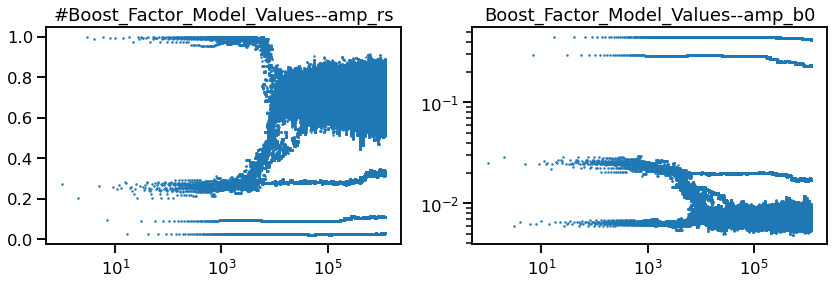

In [16]:
plt.figure(figsize=(14,4.))
plt.subplot(1, 2, 1)
column = 0; print(params[column]);
plt.xscale('log')
plt.scatter(np.arange(samples[100:,column].size),samples[100:,column], s =1);
plt.title(params[column])

plt.subplot(1, 2, 2)
column = 3; print(params[column]);
plt.xscale('log');plt.yscale('log')
plt.scatter(np.arange(samples[100:,column].size),samples[100:,column], s =1);
plt.title(params[column])


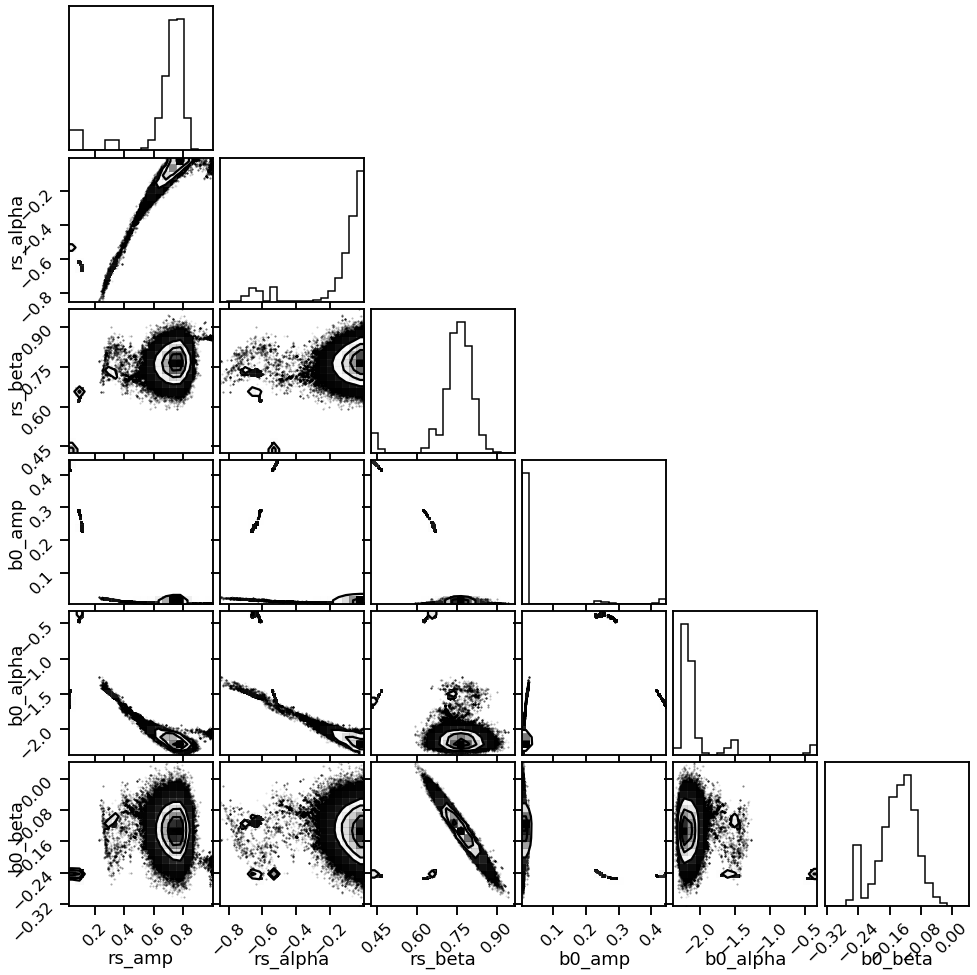

In [11]:
figure = corner.corner(samples[2000:,0:6],labels=['rs_amp','rs_alpha','rs_beta','b0_amp','b0_alpha','b0_beta'])

In [17]:
b0_best = np.median(samples[:,3])
b0_best

0.007094471967036278

In [18]:
rs_best = np.median(samples[:,0])
rs_best

0.7307268945689005

In [19]:
np.std(samples[:,0])

0.20717473675929077

In [28]:
R = np.logspace(np.log10(0.05),np.log10(6),100); # print(*R, sep=" ")
#R=p.logspace(0,1.5,2)

# true model
B0 = b0_best
R0 = rs_best
B = Boost_Factor_Model(R, R0, B0)

# add noise
variance = np.ones(B.size)*0.05**2
sigma_B  = B*np.random.normal(loc=0, scale=variance**(1/2), size=B.size) #results in log noise
data = B + sigma_B
chi_sq = ((B)-(data))**2/sigma_B**2
print(chi_sq.sum()/(B.size -1))

1.0101010101010115


In [34]:
rd, desy1 = intep_desy1_data(30,0.3)

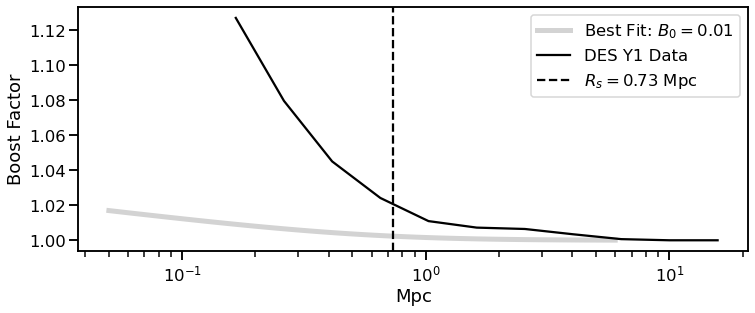

In [37]:
plt.figure(figsize=(12,4.5))
# plt.subplots_adjust(wspace=0.325)

# plt.subplot(1,2,1)
plt.xscale('log')
plt.plot(R, B, lw=5, color='lightgray',label=r'Best Fit: $B_0 =%.2f $'%(B0));
plt.xscale('log')
plt.plot(rd, desy1,color='k',label='DES Y1 Data')

plt.axvline(R0, color='k', ls='--', label=r'$R_s=%.2f$ Mpc'%R0)
plt.xlabel("Mpc"); plt.ylabel('Boost Factor')
plt.legend()

# plt.subplot(1,2,2)
# plt.xscale('log')
# plt.scatter(R, 1-1/data, color='k')
# plt.plot(R, 1-1/B, lw=5, color='lightgray');
# plt.axvline(R0, color='k', ls='--', label=r'$R_s=%.2f$'%R0)
# plt.xlabel("Mpc"); plt.ylabel(r'$f_{\rm cls}$')


# Read DES Y1 Boost-Factor Data


In [33]:
path = "/global/cfs/cdirs/des/jesteves/data/boost_factor/y1/profiles"
def read_desy1_data():
    B= dict()
    # z = np.round((np.unique(options["BoostFactor","zo_low"]) +np.unique(options["BoostFactor","zo_high"]))/2.,2)
    # l = np.round((options["BoostFactor","lo_low"] +options["BoostFactor","lo_high"])/2.,2)
    # bins = Boost_factor_util.lookup_table(l,z)

    for L in range(7):
        for Z in range(3):
            R,data_vector,sigma_B = np.genfromtxt(path+"/full-unblind-v2-mcal-zmix_y1clust_l{l}_z{z}_zpdf_boost.dat".format(l = L, z = Z),unpack=True)
            covariance = np.genfromtxt(path+"/full-unblind-v2-mcal-zmix_y1clust_l{l}_z{z}_zpdf_boost_cov.dat".format(l = L, z = Z),unpack=True)
# the error bars on the last two points of the data are tiny, so the MCMC is doing its best to fit for them. (They are tiny due to bad data)
#The following rewrites them. 
            ix=np.nonzero(sigma_B < 10**(-6))
            sigma_B[ix]=10**6
            covariance[ix,:]= 10**6
            covariance[:,ix]=10**6
            B[L,Z]=data_vector,sigma_B,covariance
    return R,B

rd, bd = read_desy1_data()
lambda_mean = priors['lambda'][0]
redshift_mean = priors['redshift'][:, 0]

def intep_desy1_data(l,z):
    L = np.interp(l,lambda_mean,range(lambda_mean.size)).astype(int)
    Z = np.interp(z,redshift_mean,range(redshift_mean.size)).astype(int)
    return rd, bd[(L,Z)][0]

In [30]:
lambda_mean = priors['lambda'][0]
lambda_mean

array([25, 40, 50, 70])

In [31]:
L = np.interp(50,lambda_mean,range(lambda_mean.size)).astype(int)
L

2

In [32]:
rd, bd = read_desy1_data()

In [545]:
bd.keys()

dict_keys([(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2), (4, 0), (4, 1), (4, 2), (5, 0), (5, 1), (5, 2), (6, 0), (6, 1), (6, 2)])

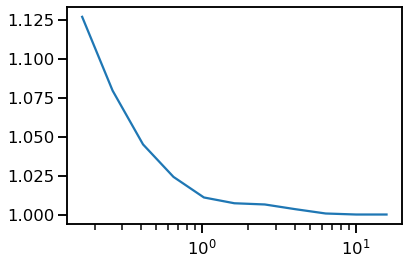

In [550]:
plt.xscale('log')
plt.plot(rd, bd[(0, 0)][0])

## Questions
- Where I put an input file on cosmosis?
- Which boost-factor data cosmosis is fitting?

In [537]:
!head -n 50 log2

head: cannot open 'log2' for reading: No such file or directory


In [21]:
samples= np.genfromtxt("boost_factor_emcee_2.txt"); 
samples = samples[500:,:-2]; 

In [22]:
samples

array([[0.58434446, 0.53157932],
       [1.52548078, 0.65978715],
       [0.31799674, 5.8291214 ],
       ...,
       [2.91405801, 0.03678384],
       [2.99688595, 0.03553587],
       [2.98935163, 0.03482564]])

In [37]:
!head boost_factor_emcee_2.txt

#Boost_Factor_Model_Values--rs	Boost_Factor_Model_Values--b0	prior	post
#sampler=emcee
#n_varied=2
#module_0=BoostFactor #name from ini file
#module_1=Boost_Factor_like #name from ini file
#timestamp=2022-11-09T08:09:46.055793
#platform=Linux-5.3.18-150300.59.87_11.0.78-cray_shasta_c-x86_64-with-glibc2.31
#platform_version=#1 SMP Thu Oct 20 22:11:23 UTC 2022 (c16132b)
#uuid=42825e603800466dbb0bf6b6b787e168
#cosmosis_git_version=


In [38]:
params = np.genfromtxt("boost_factor_emcee_2.txt", max_rows=1, comments = "%" ,dtype=str);

In [39]:
params[:3]

array(['#Boost_Factor_Model_Values--rs', 'Boost_Factor_Model_Values--b0',
       'prior'], dtype='<U30')

Boost_Factor_Model_Values--b0


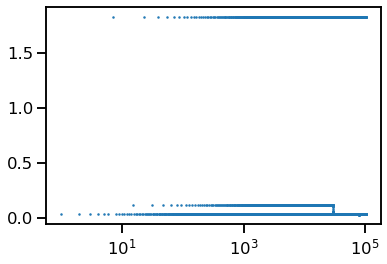

In [40]:
column = 1; print(params[column]);
plt.xscale('log')
plt.scatter(np.arange(samples[50000:,column].size),samples[50000:,column], s =1);

#Boost_Factor_Model_Values--rs


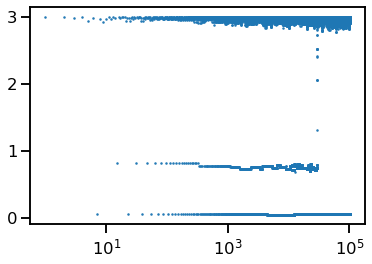

In [41]:
column = 0; print(params[column]);
plt.xscale('log')
plt.scatter(np.arange(samples[50000:,column].size),samples[50000:,column], s =1);

In [50]:
labels = []
for i in range(4):
    if i <2:
        labels.append(params[i].split('--')[1])
    else:
        labels.append(params[i])

In [51]:
labels

['rs', 'b0', 'prior', 'post']

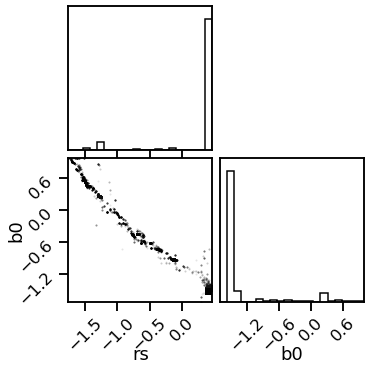

In [53]:
figure = corner.corner(np.log10(samples[500:,:]),labels=labels)